Test hyperparameter optimization for Logistic regression case

In [2]:
import sys
import torch
import torch.nn as nn
sys.path.append("..")
from hyper_opt import FixedPointHyperOptimizer
from model import BaseHyperOptModel

import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

Create Logistic Regression model and its corresponding hyperparameter-optimization wrapper

In [3]:
class LogisticRegression(nn.Module):
    
    def __init__(self, input_dim):
        super().__init__()
        self.w = nn.Parameter(torch.zeros((input_dim, 1)))
    
    def forward(self, x):
        return x @ self.w
    

class LRHyperOptModel(BaseHyperOptModel):
    
    def __init__(self, input_dim) -> None:
        network = LogisticRegression(input_dim)
        criterion = nn.BCEWithLogitsLoss()
        super().__init__(network, criterion)
        
        self.hparams = nn.Parameter(torch.ones(input_dim,1))
        
    @property
    def hyper_parameters(self):
        return [self.hparams]
    
    def regularizer(self):
        return 0.5 * (self.network.w.t() @ torch.diag(self.hparams.squeeze())) @ self.network.w


Create data

In [4]:
import numpy as np
np.random.seed(1)

n, d = 1000, 20   # num of data and num of dimension
w_oracle = np.random.randn(d)
x = np.random.randn(n, d)
y = x @ w_oracle + 0.1*np.random.randn(n)
y = (y >0.).astype(float)

x_train, y_train = torch.from_numpy(x[:n//2]).float(), torch.from_numpy(y[:n//2]).float().unsqueeze(-1)
x_val, y_val = torch.from_numpy(x[n//2:]).float(), torch.from_numpy(y[n//2:]).float().unsqueeze(-1)


# test_data
n_test = 1000
x_test = np.random.randn(n_test, d)
y_test = x_test @ w_oracle + 0.1 * np.random.randn(n_test)
y_test = (y_test > 0.).astype(float)
x_test, y_test = torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float().unsqueeze(-1)



Instantiating model + Optimizers

In [5]:
outer_steps = 500  # num of outer steps 
T, K = 100, 10  # num of inner steps and number of iterations in solvers

model = LRHyperOptModel(input_dim=d)
w_optimizer = torch.optim.SGD(model.parameters, lr=0.1)

## choose between methods
hyper_optimizer = FixedPointHyperOptimizer(model.parameters, model.hyper_parameters,default=dict(lr=1.), stochastic=False)
hyper_optimizer.set_kwargs(inner_lr=0.1)



Let's train the model

In [6]:
val_losses = []
test_losses = []
hyperparam_hist = []

def train_loss_func():
    # no minibatch
    train_loss, train_logit = model.train_loss(x_train, y_train)
    return train_loss, train_logit


for o_step in range(outer_steps):
    
    # inner optimizer
    for t in range(T):
        w_optimizer.zero_grad()
        loss, _ = model.train_loss(x_train, y_train)
        loss.backward()
        w_optimizer.step()
    
    # outer optimizer
    val_loss = model.validation_loss(x_val, y_val)
    hyper_optimizer.step(train_loss_func, val_loss, verbose=False)
    model.hyper_parameters[0].data.clamp_(min=1e-8)
    
    if o_step % 10 == 0:
        print(f"Outer step {o_step:3d} \t Val Loss: {val_loss.item():.3f}")
        test_loss = model.validation_loss(x_test, y_test)
        test_losses.append(test_loss.item())

    hyperparam_hist.append(model.hyper_parameters[0].detach().clone().numpy())
    val_losses.append(val_loss.item())
    
    

Outer step   0 	 Val Loss: 0.576
Outer step  10 	 Val Loss: 0.544
Outer step  20 	 Val Loss: 0.447
Outer step  30 	 Val Loss: 0.398
Outer step  40 	 Val Loss: 0.331
Outer step  50 	 Val Loss: 0.309
Outer step  60 	 Val Loss: 0.267
Outer step  70 	 Val Loss: 0.215
Outer step  80 	 Val Loss: 0.191
Outer step  90 	 Val Loss: 0.188
Outer step 100 	 Val Loss: 0.187
Outer step 110 	 Val Loss: 0.186
Outer step 120 	 Val Loss: 0.184
Outer step 130 	 Val Loss: 0.181
Outer step 140 	 Val Loss: 0.176
Outer step 150 	 Val Loss: 0.172
Outer step 160 	 Val Loss: 0.170
Outer step 170 	 Val Loss: 0.165
Outer step 180 	 Val Loss: 0.158
Outer step 190 	 Val Loss: 0.155
Outer step 200 	 Val Loss: 0.154
Outer step 210 	 Val Loss: 0.143
Outer step 220 	 Val Loss: 0.136
Outer step 230 	 Val Loss: 0.136
Outer step 240 	 Val Loss: 0.133
Outer step 250 	 Val Loss: 0.132
Outer step 260 	 Val Loss: 0.131
Outer step 270 	 Val Loss: 0.135
Outer step 280 	 Val Loss: 0.134
Outer step 290 	 Val Loss: 0.135
Outer step

Current implemetation CG return NaN at a large outer steps but it still converges. Neumann produces some ocsilations (which is not good)

Text(0.5, 0, 'outer steps')

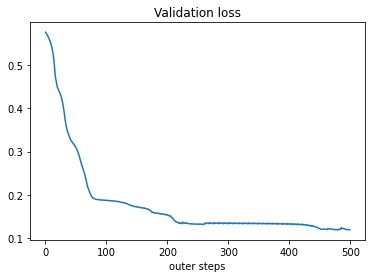

In [7]:
plt.plot(val_losses)
plt.title("Validation loss")
plt.xlabel("outer steps")


Text(0.5, 1.0, 'Test loss')

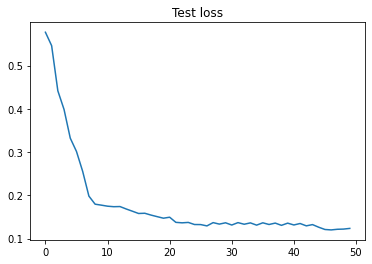

In [8]:
plt.plot(test_losses)
plt.title("Test loss")

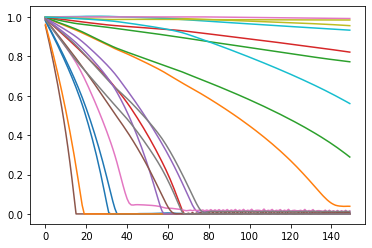

In [9]:
hyperparam_hist = [x.squeeze() for x in hyperparam_hist]
plt.plot(hyperparam_hist[:150])